# Ex 5 - Datacube for ML

This notebook briefly describes how to use the `Datacube` class for ML projects.
We will use small and non-representive datasets for the example. The aim is for you to be able to run the code and understand the core concept of integrating the datacube into your ML project.

In this example we will cover two main ML applications using the <a href='https://pytorch.org/'>Torch</a> framework:
   1. <b>Segmentation:</b> performs pixel-wise labeling with a set of object categories (for example, people, trees, sky, cars) for all image pixels.
    
   2. <b>Object classification:</b> refers to a collection of related tasks for identifying objects in digital photographs.
   
This example is dependent on installing `pytorch`, `xbatcher`.

**NOTE:** In order to execute this notebook successfully, one might have to instal extra dependencies for ML packages. Please install `ml_requirements` as mentioned in `setup.py`using `pip install -e .[ml] `

In [18]:
# Or uncomment the below line to install them.
#! pip install -e ../../.[ml] 

In [19]:
from pathlib import Path
import os
import icecube
from icecube.bin.datacube import Datacube
from icecube.bin.generate_cube import IceyeProcessGenerateCube
import xbatcher
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import xarray
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable

# Segmentation Example

In [20]:
# Read the datacube inputs
resource_dir = os.path.join(str(Path(icecube.__file__).parent.parent), "tests/resources")
grd_raster_dir = os.path.join(resource_dir, "grd_stack")
cube_config_fpath = os.path.join(resource_dir, "json_config/config_use_case5.json")

# This is file is created when you run the tests - please run `inv test` first. 
masks_labels_fpath = os.path.join(resource_dir, "labels/dummy_mask_labels.json")

#[
#    {
#        "product_file": "ICEYE_GRD_SLED_54549_20210427T215124_hollow_10x10pixels_fake_0.tif",
#        "labels": {
#            "segmentation": "/home/adupeyrat/Documents/code/icecube/tests/resources/masks/ICEYE_GRD_SLED_54549_20210427T215124_hollow_10x10pixels_fake_0.png"
#        }
#    },

In [21]:
dc = IceyeProcessGenerateCube.create_cube(grd_raster_dir, cube_config_fpath, masks_labels_fpath)

09/10/2021 07:59:39 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /mnt/xor/ICEYE_PACKAGES/icecube/tests/resources/grd_stack using GRD
processing rasters for cubes: 100%|██████████| 6/6 [00:00<00:00, 298.93it/s]
09/10/2021 07:59:39 PM - common_utils.py - [INFO] - create running time is 0.0431 seconds
09/10/2021 07:59:39 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /mnt/xor/ICEYE_PACKAGES/icecube/tests/resources/grd_stack using GRD
/home/iali/anaconda3/envs/icecube_env_test/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
processing rasters for labels cube: 100%|██████████| 6/6 [00:00<00:00, 957.68it/s]
09/10/2021 07:59:39 PM - common_utils.py - [INFO] - create running time is 0.0285 seconds


In [22]:
dc.xrdataset

<xarray.Dataset>
Dimensions:    (Azimuth: 10, Range: 10, Band: 6)
Coordinates:
  * Azimuth    (Azimuth) int64 0 1 2 3 4 5 6 7 8 9
  * Range      (Range) int64 0 1 2 3 4 5 6 7 8 9
  * Band       (Band) datetime64[ns] 2021-04-25 2021-04-26 ... 2021-04-30
Data variables:
    Intensity  (Band, Azimuth, Range) uint16 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>
    Labels     (Band, Azimuth, Range) uint8 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

The dataset contains labels and data as `np.ndarray`. For the segmentation model we will create an IterableDataset that will be used to slice the datacube in 'Azimuth' and 'Range' direction. That way we can directly map it to a deep learning model.

In [23]:
class Iceye_GRD_Loader(torch.utils.data.IterableDataset):
    def __init__(self, list_xrdataset):
        super(Iceye_GRD_Loader).__init__()
        # Change the following for your application - For the purpose of te demo we are going to concat 
        # the same dataset along a new dimension, for a real project you are going to work with multiple stacks
        # For the example purpose we will work with path of size (6, 4, 4) using xbatcher to slice our
        # xarray dataset
        concated_dataset = xarray.concat(list_xrdataset, "stack")
        self.bgen = xbatcher.BatchGenerator(concated_dataset,
                                       {'stack': 1,
                                        'Band': 6,
                                        'Azimuth': 4,
                                        'Range': 4})
    def __iter__(self):
        for batch in self.bgen:
            # Tensorflow does not accept uint16 as type
            yield torch.from_numpy(np.squeeze(batch["Intensity"].values.astype("int32"), axis=None)), torch.from_numpy(np.squeeze(batch["Labels"].values, axis=None)).float()

In [24]:
training_data = Iceye_GRD_Loader([dc.xrdataset for i in range(10)])
# We select a batch size of 2.
train_dataloader = DataLoader(training_data, batch_size=2)

In [25]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))

In [26]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([2, 6, 4, 4])
Labels batch shape: torch.Size([2, 6, 4, 4])


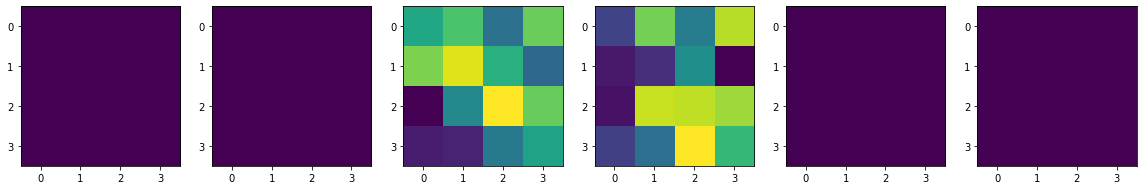

In [27]:
w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    img = train_features[0].squeeze()[i]
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(img)
plt.show()

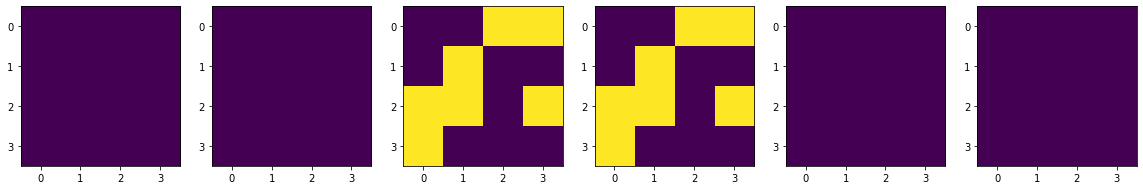

In [28]:
import numpy as np
import matplotlib.pyplot as plt

w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    img = train_labels[0].squeeze()[i]
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(img)
plt.show()

In [29]:
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, ReLU

# We build a mini model with tensorflow that will read our images and apply and 1d convolution
class MiniModel(Module):
    def __init__(self,):
        super(MiniModel, self).__init__()
        self.block1 = Sequential(
            Conv2d(6, 6, kernel_size=1, padding=0),
            ReLU()
        )

    def forward(self, x):
        return self.block1(x)

In [30]:
# Use gpu for training if available else use cpu
device = 'cpu'
# Here is the loss and optimizer definition
model = MiniModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [31]:
epochs = 50
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_dataloader, 1):
        images = images.to(device)
        masks = masks.type(torch.LongTensor)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images.float())
       
        loss = criterion(outputs.float(), masks.float()).float()  
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
        
        if (i) % 20 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.sum().item():4f}")

Epoch [1/50], Loss: 5792.898438
Epoch [2/50], Loss: 5018.459473
Epoch [3/50], Loss: 5186.329102
Epoch [4/50], Loss: 5134.431152
Epoch [5/50], Loss: 5135.608887
Epoch [6/50], Loss: 5138.066406
Epoch [7/50], Loss: 5132.810547
Epoch [8/50], Loss: 5131.064941
Epoch [9/50], Loss: 5128.675781
Epoch [10/50], Loss: 5126.311523
Epoch [11/50], Loss: 5124.213379
Epoch [12/50], Loss: 5122.261230
Epoch [13/50], Loss: 5120.495605
Epoch [14/50], Loss: 5118.917480
Epoch [15/50], Loss: 5117.520020
Epoch [16/50], Loss: 5116.307617
Epoch [17/50], Loss: 5115.276855
Epoch [18/50], Loss: 5114.426270
Epoch [19/50], Loss: 5113.753906
Epoch [20/50], Loss: 5113.257812
Epoch [21/50], Loss: 5112.934570
Epoch [22/50], Loss: 5112.781738
Epoch [23/50], Loss: 5112.795410
Epoch [24/50], Loss: 5112.974609
Epoch [25/50], Loss: 5113.313965
Epoch [26/50], Loss: 5113.810547
Epoch [27/50], Loss: 5114.461426
Epoch [28/50], Loss: 5115.263184
Epoch [29/50], Loss: 5116.211426
Epoch [30/50], Loss: 5117.304199
Epoch [31/50], Loss

Current model prediction


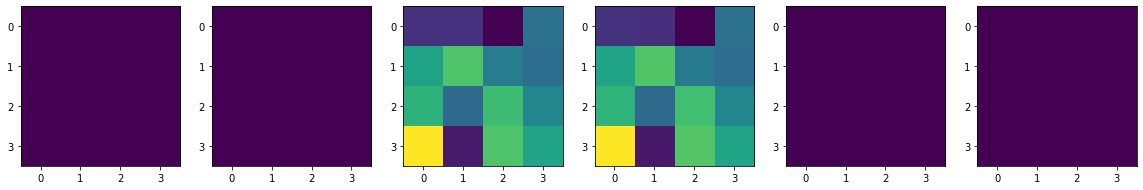

target prediction


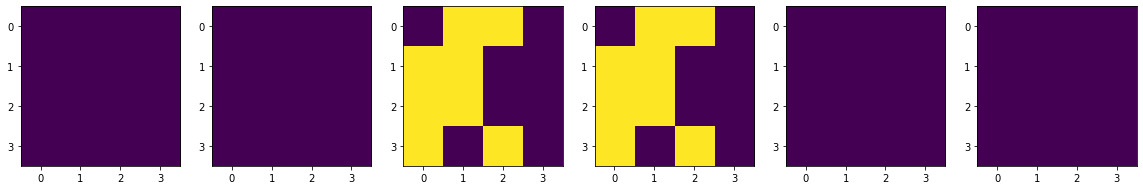

In [32]:
print("Current model prediction")
w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    output = outputs[0].squeeze()[i].detach().numpy()
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(output)
plt.show()
            
print("target prediction")
w = 20
h = 20
fig = plt.figure(figsize=(w, 8))
columns = 5
rows = 1
for i in range(0, columns*rows+1):
    mask = masks[0].squeeze()[i].detach().numpy()
    fig.add_subplot(rows, columns+1, i+1)
    plt.imshow(mask)
plt.show()

**hyvää työtä!**